In [2]:
# loading our environment, these environment files can be read in both R and Python
# convenient when workign with multiple programming languages
%load_ext dotenv
%dotenv ../src/.env

# Jupyter notebooks are experimentation things but rarely used for production
import sys
sys.path.append("../src")

# log everything, space is inexpensive; this logger is based on python
# when we call logger, it's convenient to call it "name", will give you a nice sequencing of your logs
from logger import get_logger
_logs = get_logger(__name__)

#_logs.info("Hello world!")
# value = 42
# _logs.debug(f'The value is {value}')
# _logs.error("This is an error")
# _logs.warning("this is a warnding")
# won't appear because loging level set to info, change enviroment variable to 'debug'

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [3]:
# after done programming, go back and remove unused libraries
import dask
dask.config.set({'dataframe.query-planning': True})
import dask.dataframe as dd
import pandas as pd
import numpy as np
import os
from glob import glob

In [8]:
# '.' don't mean a end of file, they are just a seperatator, it could be a folder, not necessarily a file
# creating files with .parquet file extension
ft_dir = os.getenv("FEATURES_DATA")     # PRICE_DATA

# ft_dir = os.getenv("PRICE_DATA")
# ft_glob = glob(ft_dir+'*/*.parquet')
# df = dd.read_parquet(ft_glob).compute().reset_index()

ft_glob = glob(ft_dir+'/*.parquet')

# FEATURES_DATA=../data/features/stock_features.parquet
# ft_glob = glob(ft_dir+'*/*.parquet')


df = dd.read_parquet(ft_glob).compute().reset_index()

In [5]:
ft_dir = os.getenv("PRICE_DATA")
ft_dir

'../data/prices/'

In [7]:
# this is a pattern that we use
os.path.join(ft_dir, "*/*/*.parquet")

'../data/prices/*/*/*.parquet'

In [14]:
# its a search, convveinet for searching for files ins a single flow
# find all of the files with the structure that I decide
# get only stocks that start with an 'A'
from glob import glob
glob(os.path.join(ft_dir, "A*/*/*.parquet"))

[]

In [ ]:
df = dd.read_parquet(ft_glob).compute().index()

In [ ]:
df
# ND array, pandas is a wrapper for numpy, 
# numerical computations are done with numpyt, to access underlying data you use "values()""
# pandas dataframe will alway shave an index
df.values

In [15]:
# dask data frame that has lazy executioin
# if we want pandas, we use 'compute', it will read all parquet values and calculate into pandas
# if we want to move index into pands we need to reset index
df = dd.read_parquet(ft_glob).compute().reset_index()

# Sampling in Python

+ There are different packages that allow sampling.
+ A practical approach is to use pandas/Dask sampling methods.

## Random Sampling

+ Sample n rows from a dataframe with [`df.sample()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html).

```
DataFrame.sample(
    n=None, frac=None, replace=False, weights=None, 
    random_state=None, axis=None, ignore_index=False
    )
```

In [16]:
# several ways to sample in Python
# we are sampling a pandas dataframe
# it will select rows at random, we need to give it a number of rows
# look up link provided above
# everytime run it will give different samples
# df.sample(frac = 0.1)
df.sample(n = 5)

,ticker,Date,Open,High,Low,Close,Adj Close,Volume,sector,subsector,year,Close_lag_1,returns,positive_return,target
424377,BBWI,2007-03-29,21.503637,21.697657,20.897331,21.261116,8.912901,7538031,Consumer Discretionary,Other Specialty Retail,2007,21.382378,-0.005671,0,0.0
995923,EMN,2012-02-15,54.619999,54.619999,53.410000,53.599998,38.790916,1557500,Materials,Specialty Chemicals,2012,54.139999,-0.009974,0,1.0
1771260,UNH,2020-12-07,348.720001,349.890015,345.220001,347.859985,333.675568,2999400,Health Care,Managed Health Care,2020,349.890015,-0.005802,0,0.0
904531,BEN,2003-07-07,13.360000,13.656667,13.360000,13.620000,7.588856,2442600,Financials,Asset Management & Custody Banks,2003,13.300000,0.024060,1,1.0
1496888,COP,2015-11-10,54.480000,55.150002,54.000000,54.650002,42.462162,5186800,Energy,Oil & Gas Exploration & Production,2015,54.639999,0.000183,1,0.0


In [17]:
simple_sample_dt = df.sample(frac = 0.1)
simple_sample_dt.shape, df.shape

((271386, 15), (2713855, 15))

Look at the distribution of tickers.

<Axes: >

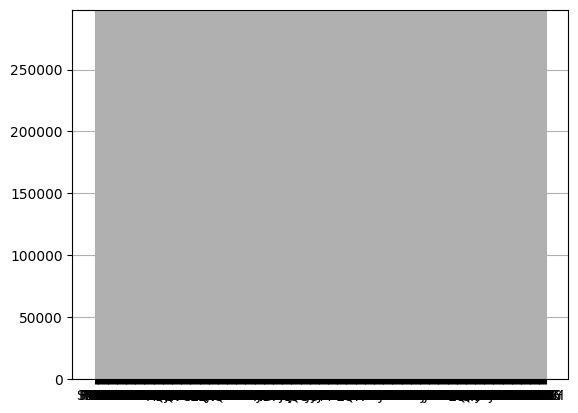

In [18]:
# expose tickker
# create histogam to display distribution of all the tickers
df['ticker'].hist()

<Axes: >

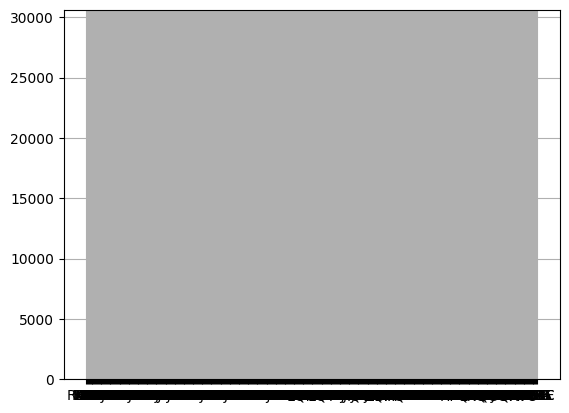

In [19]:
simple_sample_dt['ticker'].hist()

## Stratified Sampling

+ Use `groupby()` and `.sample()` for stratified sampling.

<Axes: >

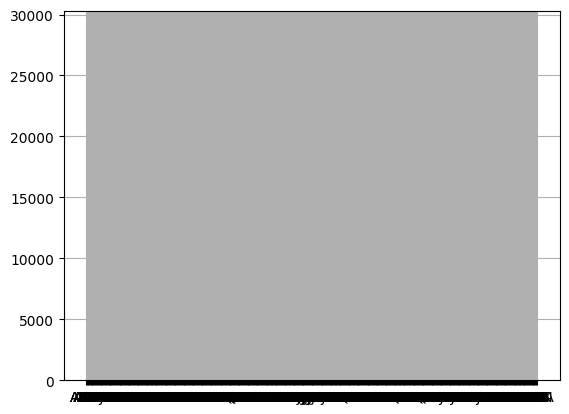

In [20]:
# simple sapmle will not take into accoutn distribution
# take sample and get 10% 
# groupby, reducing
strat_sample_dt = df.groupby(['ticker']).sample(frac = 0.1)
strat_sample_dt['ticker'].hist()

# Sampling in Dask

+ Stratified sampling in `dask` can be achieved with `groupby().apply()` and a lambda function.

C:\Users\bash\AppData\Local\Temp\ipykernel_2976\3864709739.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  .apply(lambda x: x.sample(frac = 0.1)).compute())


<Axes: >

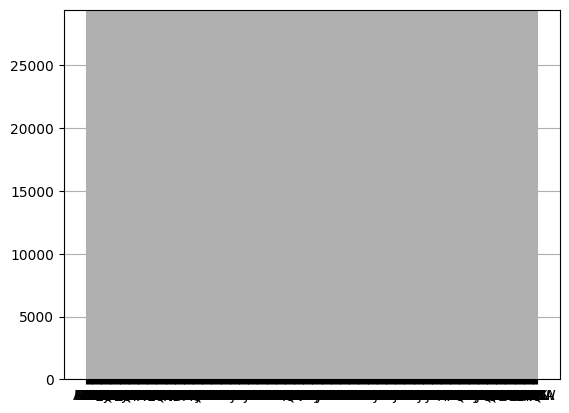

In [21]:
# a map reduce algorithm
# groupby 
# apply(lambda x: x.sample(frac = 0.1)).compute()) important
# applying a function that does not exist, encapsulate everything in a single line
# function will receive on arguement, the group defined, the dataframe that has only one ticker "A"
# every group will have only a single ticker (prices, ticker)
# take that sample and concatonante
# operating on a dask dataframe
dd_dt = dd.read_parquet(ft_glob)
strat_sample_dd_dt = (dd_dt
                      .groupby('ticker', group_keys=False)
                      .apply(lambda x: x.sample(frac = 0.1)).compute())
strat_sample_dd_dt.reset_index()['ticker'].hist()